In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import re
import time
%matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import textwrap
import scipy.stats as stats

from scipy import stats
import scipy
from functools import partial

import matplotlib.pylab as pylab
import seaborn as sns
sns.set_style('whitegrid', {'legend.frameon':True})
sns.set_palette(sns.color_palette("Set1", 12))
#sns.set_context("paper")
fontsize = 12
params = {
    'legend.fontsize': fontsize,
    'figure.figsize': (6.7, 5),
    'figure.dpi': 200,
    'axes.labelsize': fontsize,
    'axes.titlesize':fontsize,
    'axes.edgecolor':"0.3",
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    'legend.fontsize':10,
    'font.size':fontsize,
    'font.family':'serif'
}
pylab.rcParams.update(params)
plt.rc('axes', labelsize=fontsize) 

#plt.style.use('ggplot')
%matplotlib inline

from tqdm.notebook import tqdm
import pandas as pd
from pathlib2 import Path
import os

Using matplotlib backend: Qt5Agg


In [2]:
import sys
sys.path.append('../')

from metric_store import save_metrics, save_metric, load_metrics, get_metric_names, load_metric
from network_metrics import prepare_metric
from pipeline.pipeline import load_config

In [3]:
config_name = "pipeline.config"
config = load_config(config_name)
work_dir = config.download_ERA5_options['work_dir']
image_dir = work_dir / 'results_histogram' / 'max_deviation_region'
image_dir.mkdir(parents=True, exist_ok=True)

In [4]:
from corr_network import load_data, get_available_mask
data = load_data(config)
available_mask = get_available_mask(data)

In [ ]:
metric_names = ['input_data/MSLP_preproc']
for metric_name in metric_names:
    config.metrics_plot_options['metric_name'] = metric_name
    metric = load_metric(config, metric_name)
    metric = prepare_metric(metric_name, metric, available_mask)
    print(metric_name, metric.shape, config.metric_dimension[metric_name])

In [46]:
prefix = 'lgm_deviation_for_cyclones'
metric_names = list(get_metric_names(config, prefix = prefix).keys())
metric_names

['lgm_deviation_for_cyclones/probability_for_metrics/network_metrics/LCC_w',
 'lgm_deviation_for_cyclones/probability_for_metrics/network_metrics/degree_w',
 'lgm_deviation_for_cyclones/probability_for_metrics/network_metrics/EVC_w',
 'lgm_deviation_for_cyclones/probability_for_metrics/network_metrics/closeness_w',
 'lgm_deviation_for_cyclones/probability_for_metrics/network_metrics/LCC_0.9',
 'lgm_deviation_for_cyclones/probability_for_metrics/network_metrics/degree_0.9',
 'lgm_deviation_for_cyclones/probability_for_metrics/network_metrics/EVC_0.9',
 'lgm_deviation_for_cyclones/probability_for_metrics/network_metrics/closeness_0.9',
 'lgm_deviation_for_cyclones/probability_for_metrics/network_metrics/LCC_0.95',
 'lgm_deviation_for_cyclones/probability_for_metrics/network_metrics/degree_0.95',
 'lgm_deviation_for_cyclones/probability_for_metrics/network_metrics/EVC_0.95',
 'lgm_deviation_for_cyclones/probability_for_metrics/network_metrics/closeness_0.95',
 'lgm_deviation_for_cyclones/

In [6]:
os.chdir('..')

array([[ True,  True, False, False],
       [ True,  True, False, False]])

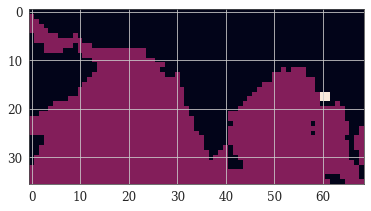

In [7]:
maskt = available_mask.copy().astype('int8')
maskt[17:19, 60:62] = 3
plt.imshow(maskt)
available_mask[17:19, 58:62]

In [18]:
from corr_network import load_data, get_available_mask
from metric_store import get_metric_names, save_metric, load_metric
from network_metrics import prepare_metric
from plot_network_metrics.utils import get_times_lats_lots  ###
from cyclones_info.cyclones_info import get_cyclones_info, get_cyclones
from cyclone_metrics import compute_max_deviation
from tqdm import tqdm
from g_test_for_metrics.g_test_for_metrics import get_sign_for_metric

all_times, all_lats, all_lons = get_times_lats_lots(config)
cyclones_frame = get_cyclones_info(config)
cyclones_dict = get_cyclones(cyclones_frame, config.cyclone_metrics_options)

track_size = 2

metric_name = 'probability_for_metrics/network_metrics/LCC_w'

metric = load_metric(config, metric_name)
metric = prepare_metric(metric_name, metric, available_mask)

main_metric_name = metric_name[metric_name.find("/") + 1:]
sign = get_sign_for_metric(config, main_metric_name)
        
local_metric_max_deviation = compute_max_deviation(metric, cyclones_frame, cyclones_dict, all_times, all_lons, 
                    all_lats, opt_func='max' if sign == '>' else 'min', track_size=track_size)
                

here 0
[22, 24, 44, 46, 961]
[[0.487  0.6694]
 [0.617  0.4841]]
0.4841
here 1
[21, 23, 44, 46, 962]
[[0.3267 0.4348]
 [0.2563 0.5703]]
0.2563
here 2
[21, 23, 44, 46, 963]
[[0.3064 0.4082]
 [0.2544 0.6226]]
0.2544
here 3
[21, 23, 43, 45, 964]
[[0.2854  0.2374 ]
 [0.3982  0.09607]]
0.09607
here 4
[21, 23, 43, 45, 965]
[[0.1895 0.2172]
 [0.2201 0.1001]]
0.1001
here 5
[20, 22, 44, 46, 966]
[[0.0877  0.1683 ]
 [0.08923 0.1106 ]]
0.0877
here 6
[20, 22, 44, 46, 967]
[[0.0839  0.05792]
 [0.0751  0.0714 ]]
0.05792
here 7
[19, 21, 44, 46, 968]
[[0.2925 0.2585]
 [0.3518 0.2988]]
0.2585
here 8
[19, 21, 45, 47, 969]
[[0.1825  0.1963 ]
 [0.278   0.11847]]
0.11847
here 9
[19, 21, 46, 48, 970]
[[0.0258   0.01627 ]
 [0.00807  0.010124]]
0.00807
here 10
[19, 21, 46, 48, 971]
[[0.002932  0.00401  ]
 [0.0006757 0.0004652]]
0.0004652
here 11
[19, 21, 46, 48, 972]
[[0.012665  0.01227  ]
 [0.0019045 0.001159 ]]
0.001159
here 12
[19, 21, 46, 48, 973]
[[0.01436  0.01343 ]
 [0.003746 0.002562]]
0.002562
here 13

d:\PC\UNN\Science\Climate\programs\climate-networks\src\notebooks\..\cyclone_metrics\cyclone_metrics.py:144: RuntimeWarning: All-NaN slice encountered
  c_metric_max_deviation.append(res)


here 0
[13, 15, 26, 28, 1561]
[[0.3008 0.3564]
 [0.2998 0.276 ]]
0.276
here 1
[13, 15, 26, 28, 1562]
[[0.1028  0.11957]
 [0.1362  0.0796 ]]
0.0796
here 2
[13, 15, 26, 28, 1563]
[[0.05865 0.07666]
 [0.02602 0.04535]]
0.02602
here 3
[13, 15, 24, 26, 1564]
[[0.1102  0.1287 ]
 [0.0909  0.07666]]
0.07666
here 4
[13, 15, 24, 26, 1565]
[[0.2307 0.3079]
 [0.2301 0.1333]]
0.1333
here 5
[13, 15, 24, 26, 1566]
[[0.269  0.344 ]
 [0.2332 0.1472]]
0.1472
here 6
[13, 15, 24, 26, 1567]
[[0.2437 0.4617]
 [0.1711 0.2024]]
0.1711
here 7
[13, 15, 24, 26, 1568]
[[0.291  0.4324]
 [0.1991 0.1664]]
0.1664
here 8
[11, 13, 23, 25, 1569]
[[0.7817 0.8   ]
 [0.694  0.6406]]
0.6406
here 9
[11, 13, 23, 25, 1570]
[[0.6606 0.6978]
 [0.679  0.575 ]]
0.575
here 10
[11, 13, 23, 25, 1571]
[[0.359  0.4102]
 [0.551  0.1697]]
0.1697
here 11
[11, 13, 23, 25, 1572]
[[0.425  0.5063]
 [0.4983 0.0559]]
0.0559
here 0
[17, 19, 51, 53, 1585]
[[0.638   0.3662 ]
 [0.595   0.09937]]
0.09937
here 1
[17, 19, 51, 53, 1586]
[[0.504  0.345 

In [47]:
def load_cyclone_lgm_deviations(metric_names, track_size):
    cyclone_lgm_deviations_metric_values = {}
    config.metrics_plot_options['track_size'] = track_size
    print(config.metrics_plot_options['track_size'])
    for metric_name in metric_names:
        if not f'track_size_{track_size}' in metric_name:
            continue
        config.metrics_plot_options['metric_name'] = metric_name
        metric = load_metric(config, metric_name).item()
        cyclone_lgm_deviations_metric_all = []
        for cyclone_name, cyclone_lgm_deviations in metric.items():
            cyclone_lgm_deviations_metric = np.array(cyclone_lgm_deviations['metrics'])
            cyclone_lgm_deviations_metric = cyclone_lgm_deviations_metric[~np.isnan(cyclone_lgm_deviations_metric)]
            cyclone_lgm_deviations_metric_all += [cyclone_lgm_deviations_metric]
        cyclone_lgm_deviations_metric_all = np.concatenate(cyclone_lgm_deviations_metric_all)
        cyclone_lgm_deviations_metric_values[metric_name] = cyclone_lgm_deviations_metric_all
    return cyclone_lgm_deviations_metric_values

In [48]:
cyclone_lgm_deviations_metric_values_1 = load_cyclone_lgm_deviations(metric_names, track_size=2)
cyclone_lgm_deviations_metric_values_4 = load_cyclone_lgm_deviations(metric_names, track_size=8)

2
8


In [51]:
print(cyclone_lgm_deviations_metric_values_1['lgm_deviation_for_cyclones/track_size_2/probability_for_metrics/network_metrics/LCC_w'])
print(cyclone_lgm_deviations_metric_values_4['lgm_deviation_for_cyclones/track_size_8/probability_for_metrics/network_metrics/LCC_w'])

[0.48413086 0.25634766 0.25439453 ... 0.05368042 0.05380249 0.08477783]
[2.01049805e-01 1.54418945e-01 1.27807617e-01 ... 1.75237656e-05
 0.00000000e+00 8.07285309e-04]


In [60]:
from textwrap import wrap
"\n".join(wrap('lgm_deviation_for_cyclones/track_size_8/probability_for_metrics/network_metrics/LCC_w'.replace('/', ' '), width=50))

'lgm_deviation_for_cyclones track_size_8\nprobability_for_metrics network_metrics LCC_w'

In [64]:
def plot_hist_metric(metric, metric_name):
    plt.figure(dpi=300)
    sns.kdeplot(metric)
    from textwrap import wrap
    xlabel = "\n".join(wrap(metric_name.replace('$', ' ').replace('/', ' '), width=50)).replace(' ', ' / ').replace('_', ' ')
    plt.xlabel(xlabel)
    plt.xlim([0, 1])
for track_size in config.g_test_options['track_sizes']:
    cyclone_lgm_deviations_metric_values = load_cyclone_lgm_deviations(metric_names, track_size)
    for metric_name, cyclone_lgm_deviations in cyclone_lgm_deviations_metric_values.items():
        metric_name = metric_name.split('/')
        main_metric_name = metric_name[1] + '/' + "$".join(metric_name[:1] + metric_name[2:])
        plot_hist_metric(cyclone_lgm_deviations, main_metric_name)
        file_name = image_dir / (main_metric_name + '.png')
        file_name.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(file_name, bbox_inches='tight')
        plt.close()
    

2
4
6
8
10
12


2
4
6
8
10
12


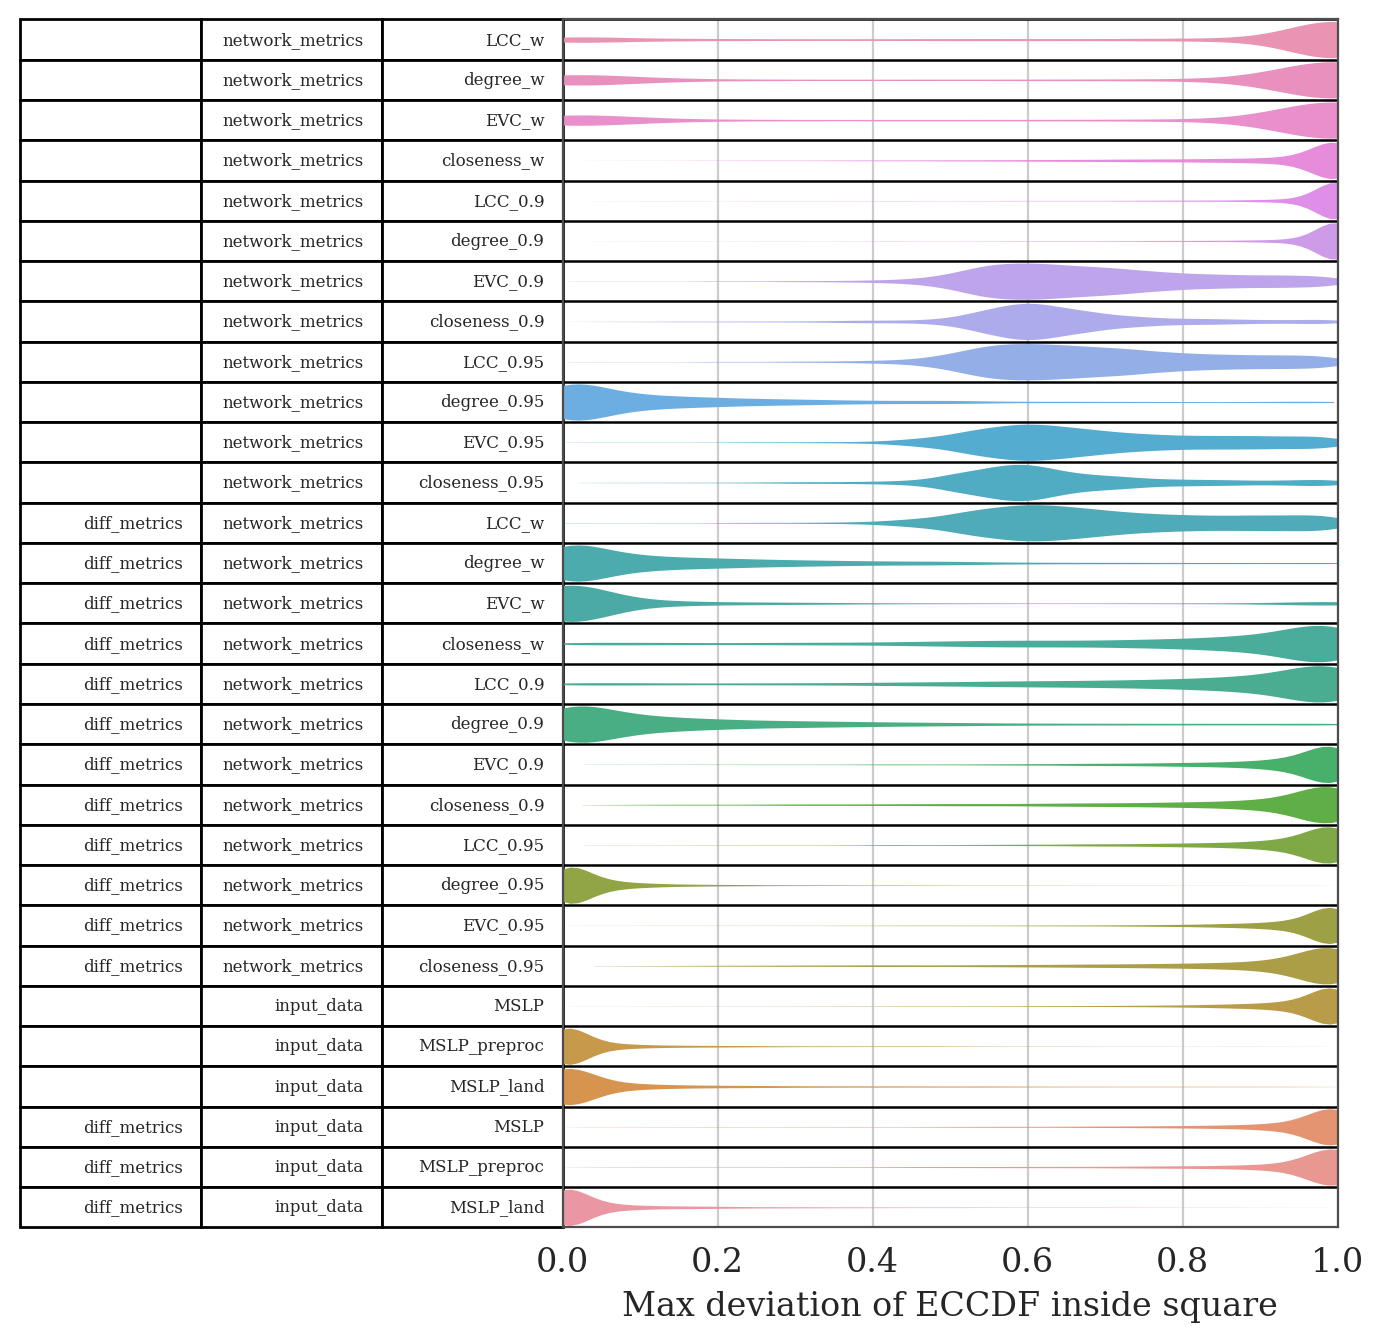

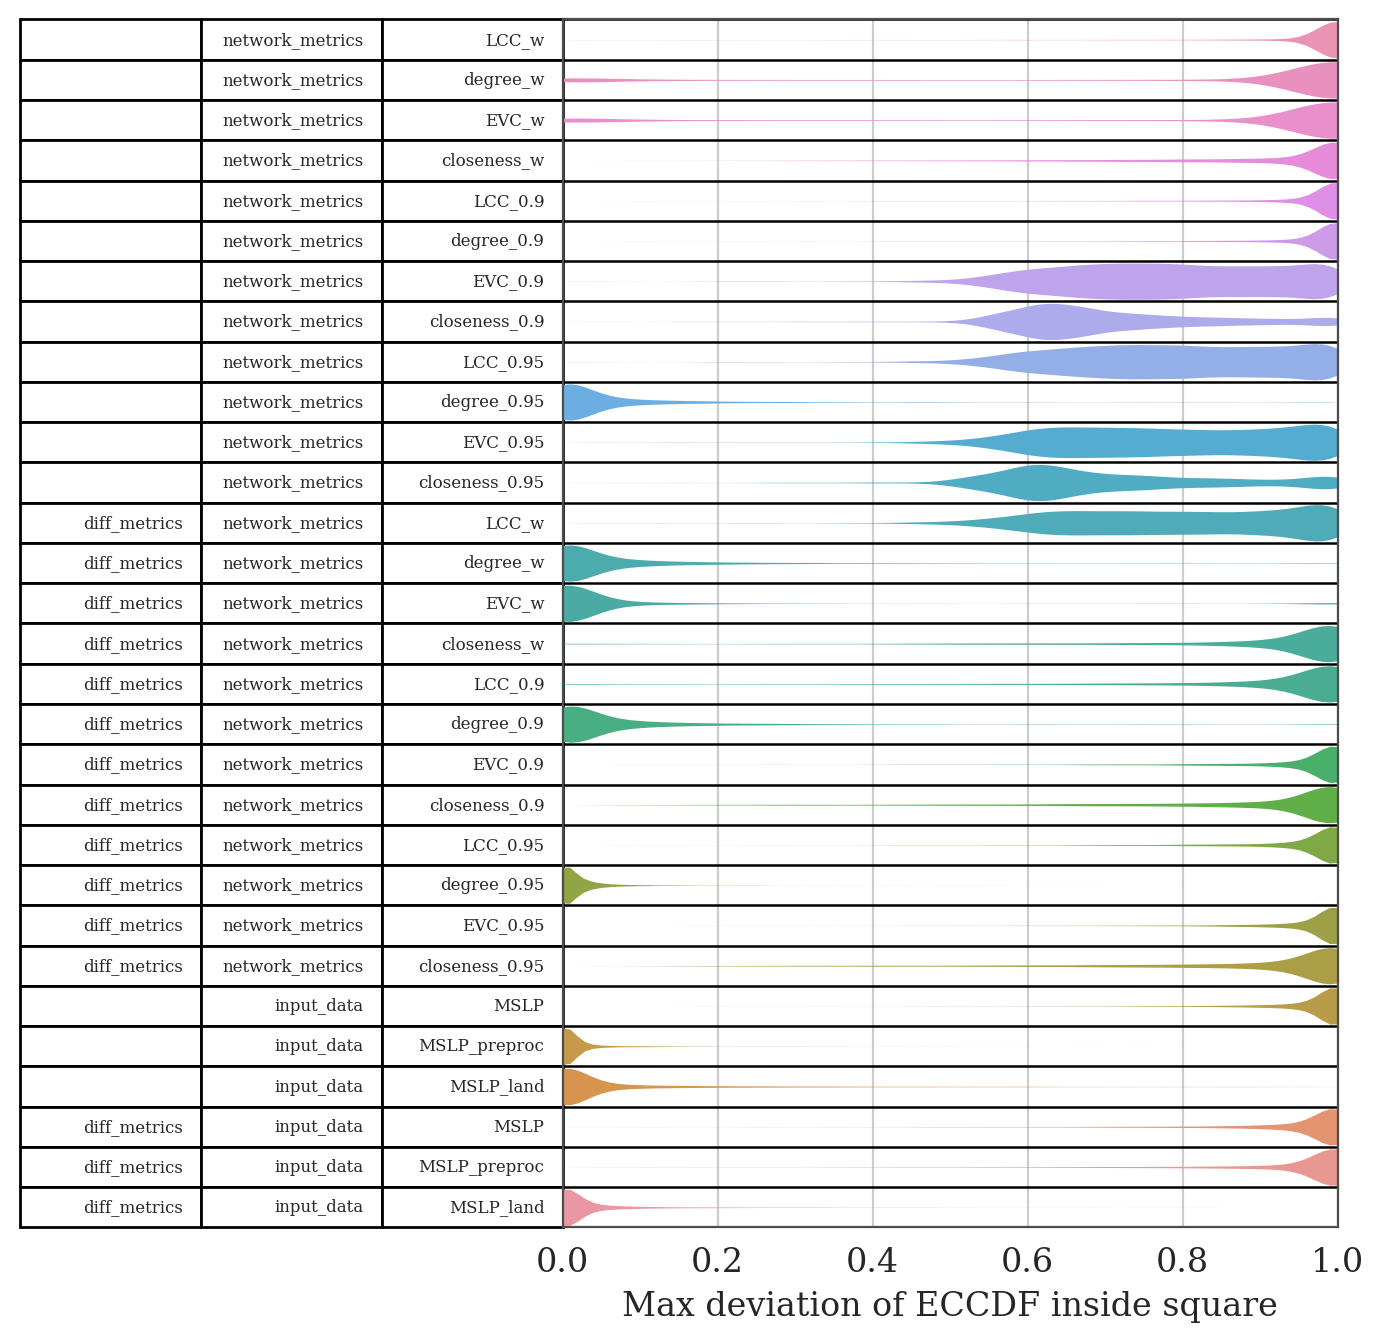

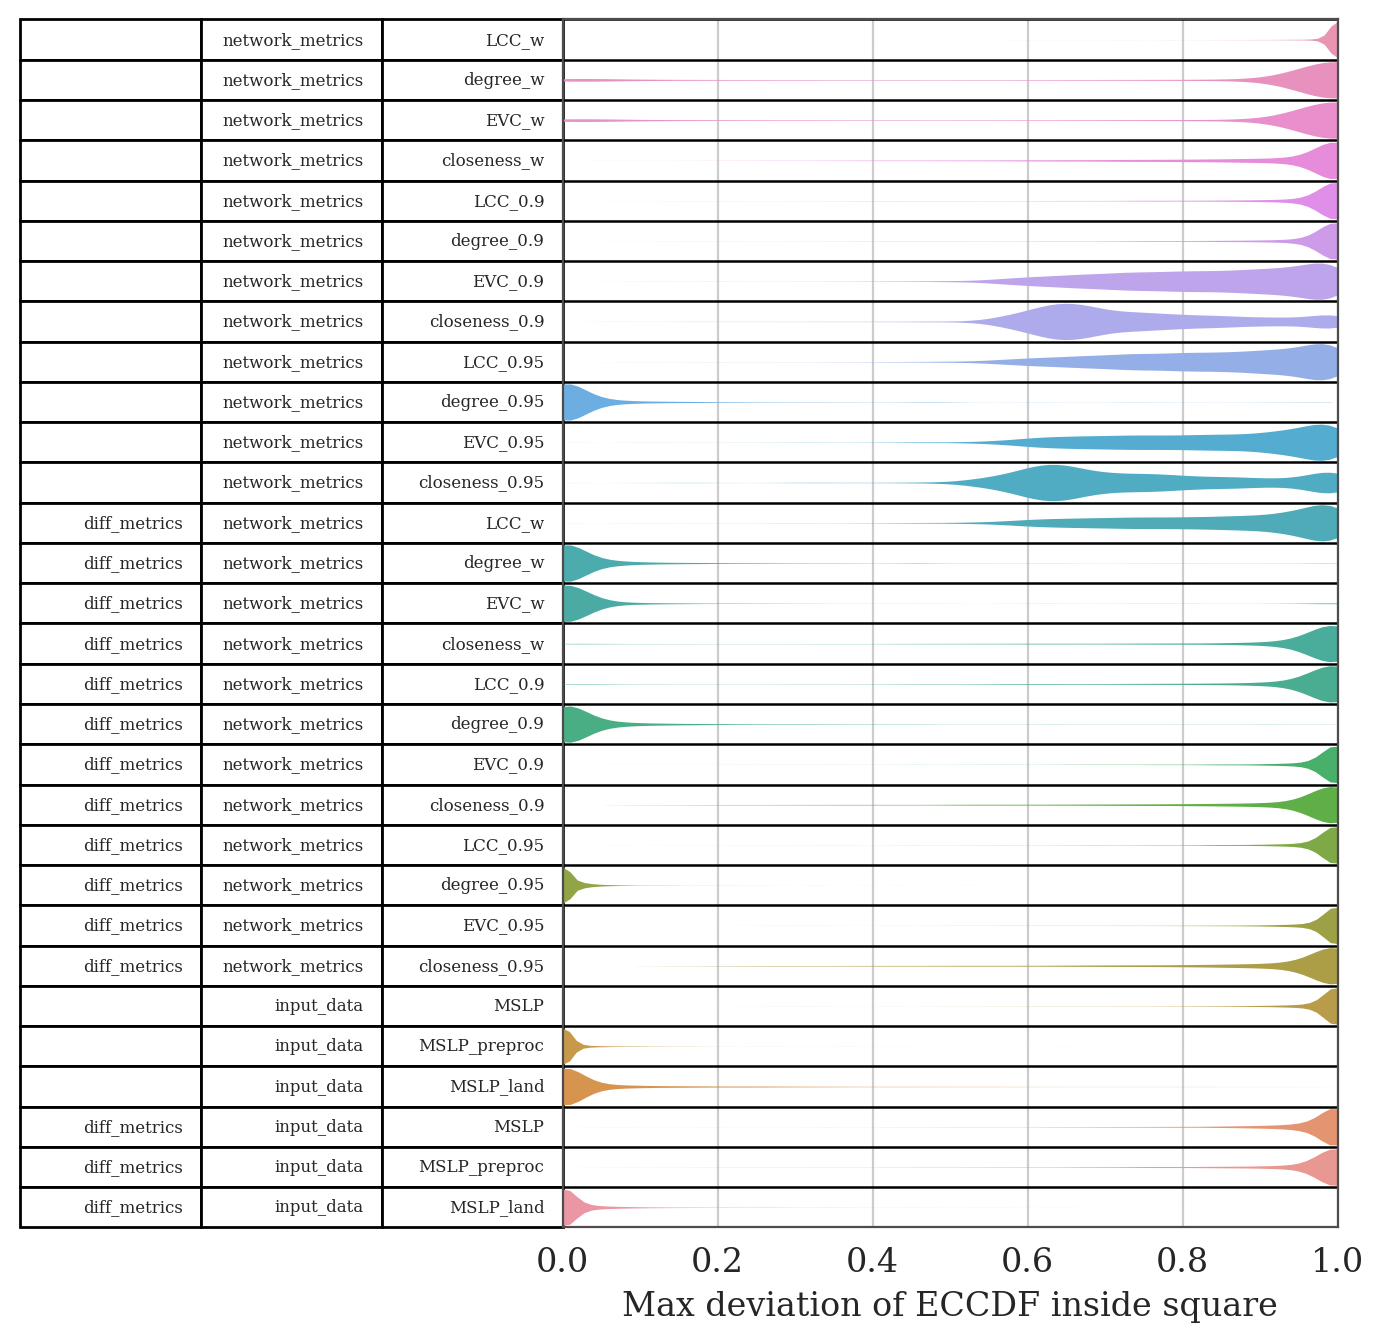

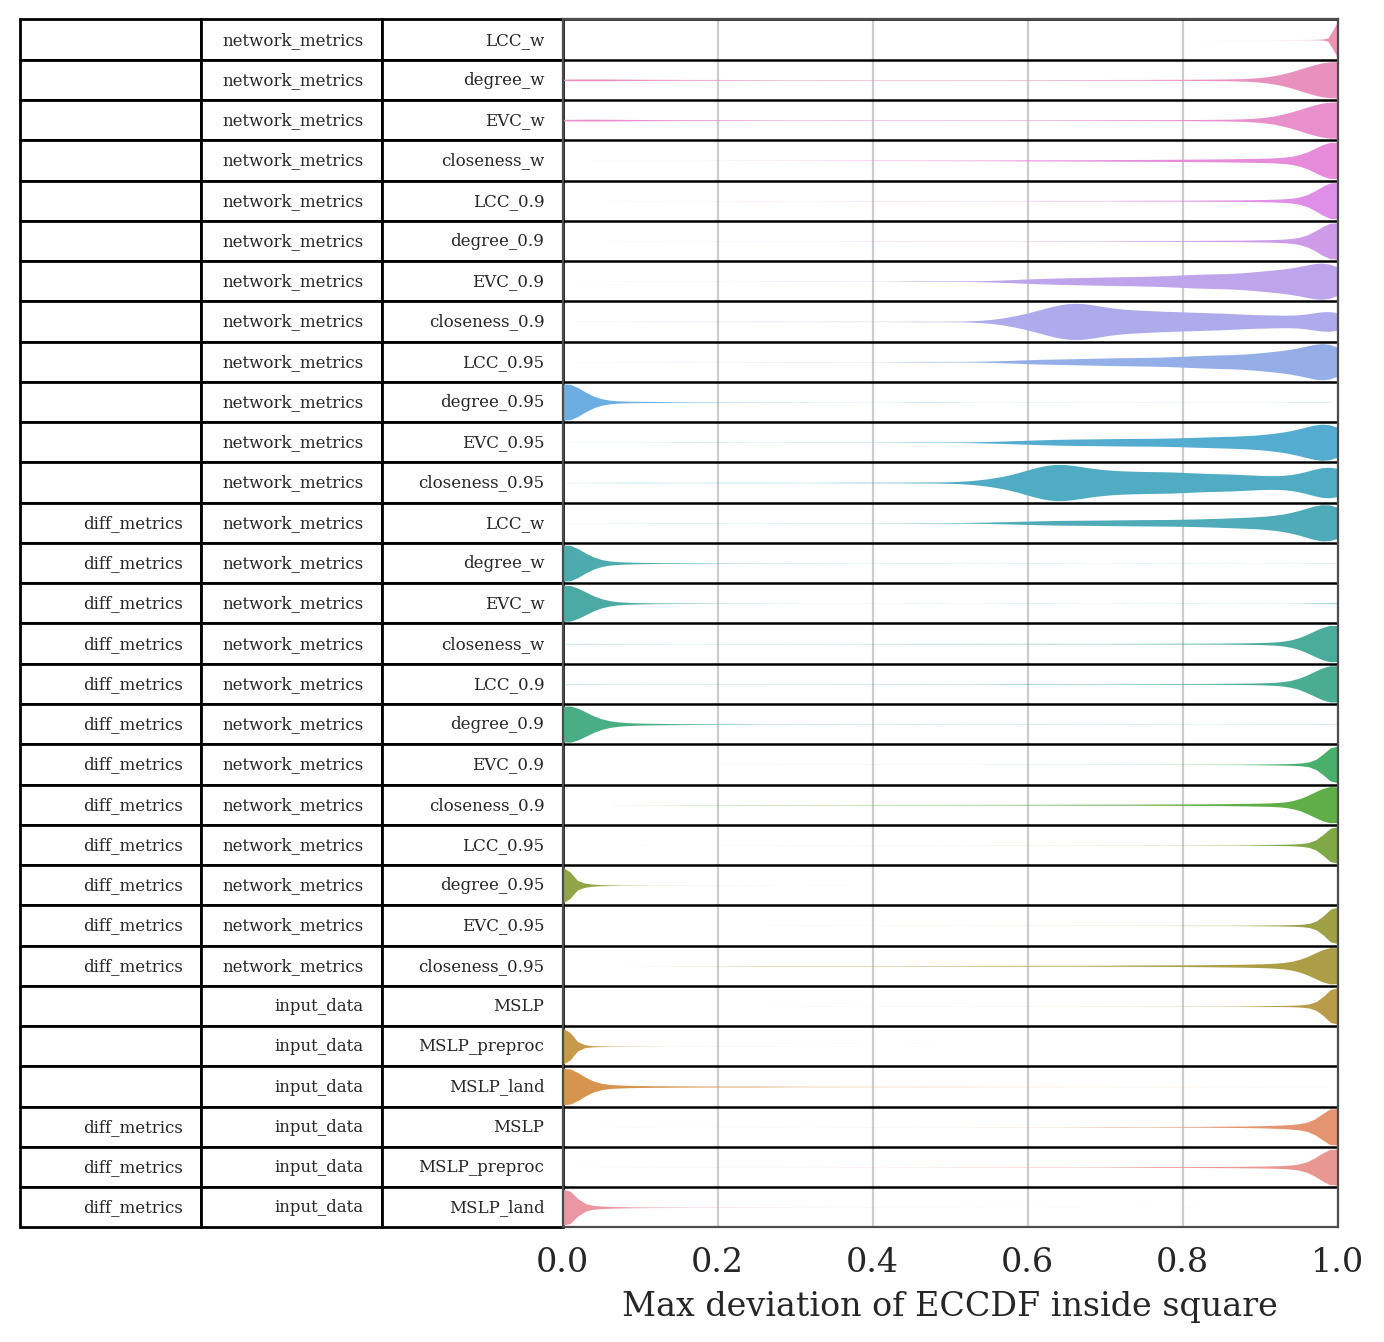

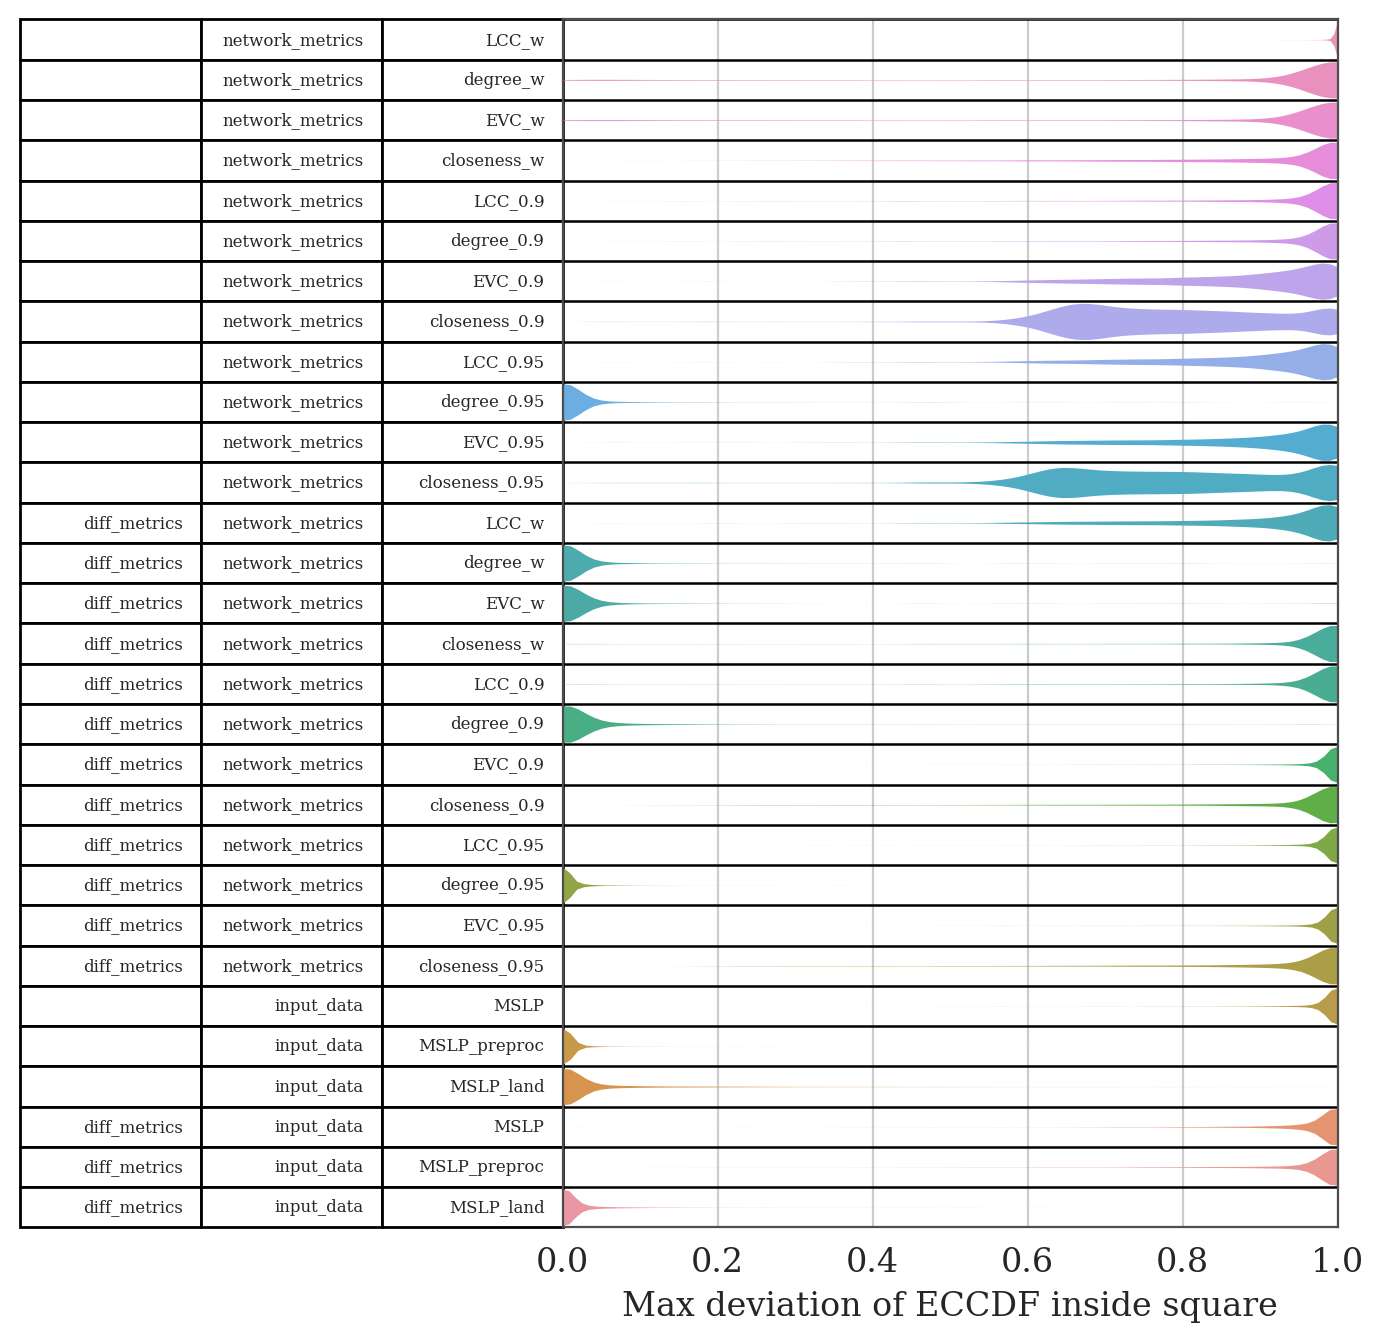

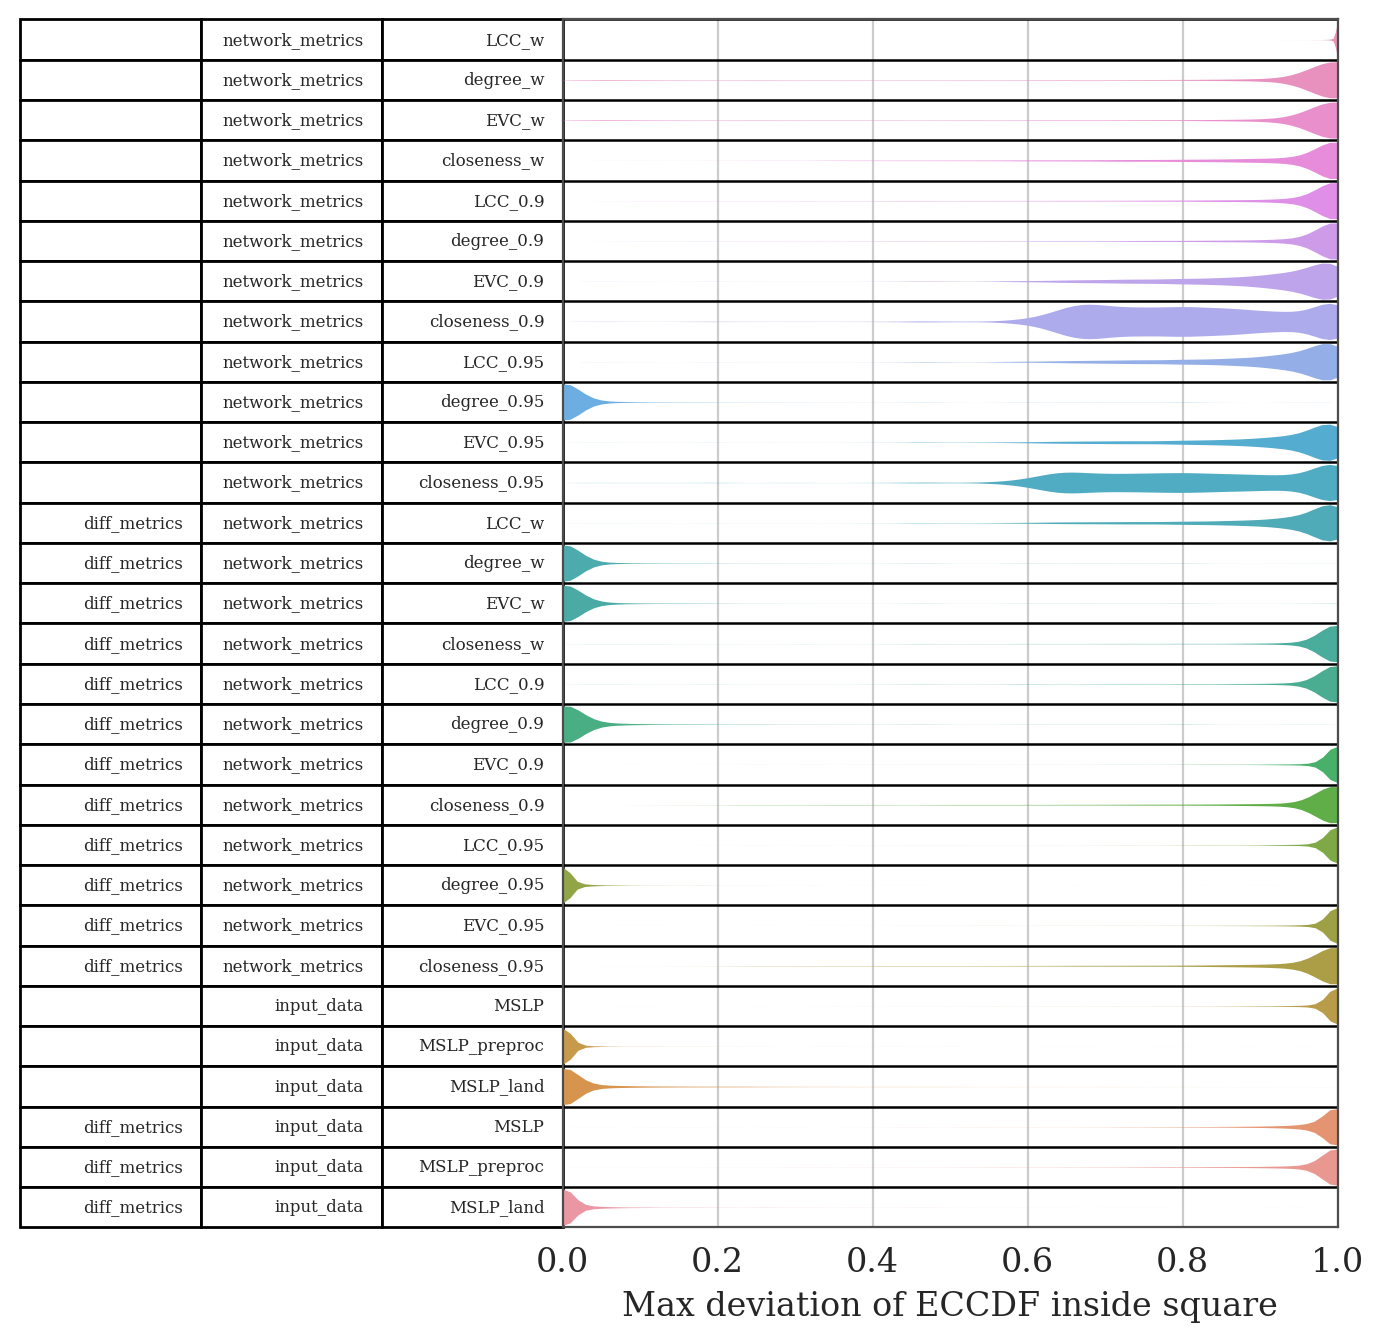

In [65]:
def plot_table_violinplot(cyclone_lgm_deviations_metric_values):
    plt.figure(figsize=(5, 8), dpi=200)
    deviation_metric_names = list(cyclone_lgm_deviations_metric_values.keys())
    #deviation_metric_names = ["     ".join(metric_name.split('/')[2:]) for metric_name in deviation_metric_names]
    deviation_metric_names = [metric_name.split('/')[3:] for metric_name in deviation_metric_names]
    deviation_metric_names = [[''] * (3 - len(metric_name)) + metric_name for metric_name in deviation_metric_names]
    plt.table(deviation_metric_names, loc='left', bbox=(-0.7, 0, 0.7, 1))
    sns.violinplot(data=list(cyclone_lgm_deviations_metric_values.values()), orient='h', linewidth=0, width=0.9, cut=0, scale='width')
    for i in range(len(deviation_metric_names)):
        plt.plot([0, 1], [i + 0.5, i + 0.5], 'k', lw=0.9)
    plt.xlim([0, 1])
    plt.ylim([-0.5, len(deviation_metric_names)-0.5])
    plt.xlabel('Max deviation of ECCDF inside square')
    plt.gca().set_yticklabels([])

for track_size in config.g_test_options['track_sizes']:
    cyclone_lgm_deviations_metric_values = load_cyclone_lgm_deviations(metric_names, track_size)
    plot_table_violinplot(cyclone_lgm_deviations_metric_values)
    file_name = image_dir / (f'cyclone_lgm_deviations_boxplot_track_size_{track_size}.png')
    plt.savefig(file_name, bbox_inches='tight')

In [33]:
type(metric.item())

dict

In [24]:
metric

array({'1982_cyclone_1__1982-05-01_1982-05-05': {'times': ['1982.05.01 03:00:00', '1982.05.01 06:00:00', '1982.05.01 09:00:00', '1982.05.01 12:00:00', '1982.05.01 15:00:00', '1982.05.01 18:00:00', '1982.05.01 21:00:00', '1982.05.02 00:00:00', '1982.05.02 03:00:00', '1982.05.02 06:00:00', '1982.05.02 09:00:00', '1982.05.02 12:00:00', '1982.05.02 15:00:00', '1982.05.02 18:00:00', '1982.05.02 21:00:00', '1982.05.03 00:00:00', '1982.05.03 03:00:00', '1982.05.03 06:00:00', '1982.05.03 09:00:00', '1982.05.03 12:00:00', '1982.05.03 15:00:00', '1982.05.03 18:00:00', '1982.05.03 21:00:00', '1982.05.04 00:00:00', '1982.05.04 03:00:00', '1982.05.04 06:00:00', '1982.05.04 09:00:00', '1982.05.04 12:00:00', '1982.05.04 15:00:00', '1982.05.04 18:00:00', '1982.05.04 21:00:00', '1982.05.05 00:00:00', '1982.05.05 03:00:00', '1982.05.05 06:00:00', '1982.05.05 09:00:00', '1982.05.05 12:00:00'], 'metrics': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 